In [1]:
from sys import stdout
from os.path import join, isdir, isfile, exists
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import scipy.integrate as integrate
from random import sample
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import time
from lib import getMinMaxDates, on_times, train, prob_duration, prob_time_new, prob_duration, slot

In [2]:
# load the preprocessed dataset just with the washing machines
# uncomment to make the analysis for other devices as well
machines = pd.read_hdf('./refit_dish_washers.h5')

In [3]:
# Calculate the common min and max dates from all washing machines
(mindate,maxdate) = getMinMaxDates(machines)
print(mindate, maxdate)

2014-06-03 11:30:00 2015-05-22 15:15:00


In [4]:
# set the date up to which the trainset will be defined
timedelta = maxdate-mindate
trainset = mindate + timedelta/2

In [5]:
# how many days per average is the washing machine open?
idx = pd.IndexSlice
for i in np.unique(machines.index.get_level_values('building')):
    mask = machines.index.get_level_values('building') == i
    app = machines.loc[idx[mask, :, mindate:maxdate]]
    #print(on_times(app).index.get_level_values)
    print(f"Building: {i}")
    print(f"Days open (from the 168 days in total): {(len(np.unique(on_times(app).index.date)) * 100.0)/len(np.unique(app.index.get_level_values('Unix').date)):.2f}%")

Building: 1
Days open (from the 168 days in total): 26.27%
Building: 2
Days open (from the 168 days in total): 73.73%
Building: 3
Days open (from the 168 days in total): 66.38%
Building: 5
Days open (from the 168 days in total): 65.25%
Building: 6
Days open (from the 168 days in total): 17.51%
Building: 7
Days open (from the 168 days in total): 77.97%
Building: 9
Days open (from the 168 days in total): 63.56%
Building: 10
Days open (from the 168 days in total): 72.32%
Building: 11
Days open (from the 168 days in total): 9.89%
Building: 13
Days open (from the 168 days in total): 38.42%
Building: 15
Days open (from the 168 days in total): 3.11%
Building: 16
Days open (from the 168 days in total): 57.34%
Building: 18
Days open (from the 168 days in total): 33.62%
Building: 20
Days open (from the 168 days in total): 31.64%
Building: 21
Days open (from the 168 days in total): 67.23%


In [6]:
# train and derive the probabilities for all households
prob_times, prob_days, prob_dur = train(machines, mindate, trainset)

The appliance was on 1 time


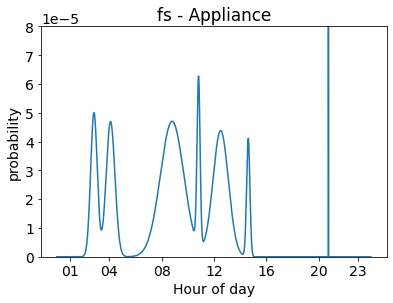

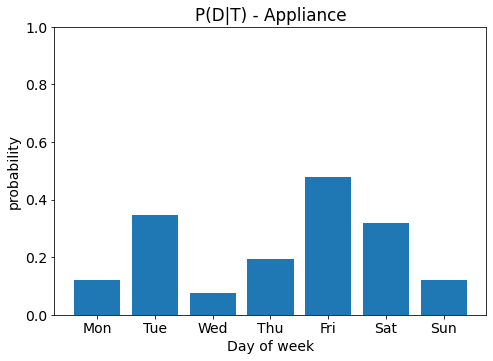

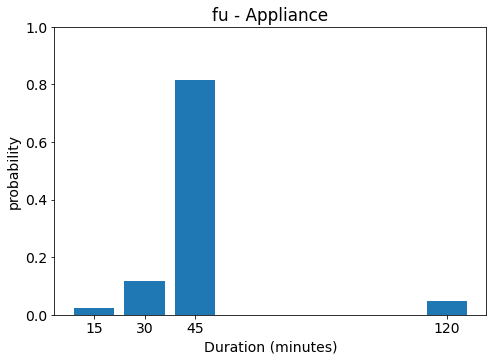

In [7]:
import matplotlib.pyplot as plt

app_no = 0

title_addition = " - Appliance"

plt.rcParams.update({'font.size': 14})

# Probability on given hour of day
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
plt.plot(prob_times[app_no])
plt.ylabel('probability')
ticks = [1*60*60, 4*60*60, 8*60*60, 12*60*60, 16*60*60, 20*60*60, 23*60*60]
labels = ['01', '04', '08', '12', '16', '20', '23']
ax.set_ylim(0,8e-5)
ax.set_xlabel('Hour of day')
ax.set_title('fs' + title_addition)
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
plt.show()

# Probability on given day
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
probability = prob_days[app_no]
ax.bar(days, probability)
ax.set_ylim(0,1)
ax.set_title('P(D|T)' + title_addition)
ax.set_xlabel('Day of week')
plt.ylabel('probability')
plt.show()


# Probability duration 
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
quarters = prob_dur[app_no].index.values
labels = np.multiply(quarters, 15)
probability = prob_dur[app_no]['duration'].values
ax.bar(quarters, probability)
ax.set_ylim(0,1)
ax.set_title('fu' + title_addition)
ax.set_xlabel('Duration (minutes)')
ax.set_xticks(quarters)
ax.set_xticklabels(labels)
plt.ylabel('probability')
plt.show()

## Run the experiment

In [8]:
# for subset
subset = list(range(2,12,2))
# for timeslots
timeslots_list = [
     ('17:00:00', '19:00:00'), 
     ('07:00:00', '09:00:00'), 
     ]
# for runs
number_of_runs = 5

final_grid_results = pd.DataFrame(columns=['subset', 'timeslot', 'f1_selected_score', 'f1_random_score', 'precision_selected', 'precision_random', 'recall_selected', 'recall_random', 'auc_selected', 'auc_random'])

buildings_list = np.unique(machines.index.get_level_values('building')).tolist()

app_subset = machines

selected_power = 0
aggregated_power = 0
days = 0

# Run the experiment

for time_on, time_off in timeslots_list:
    precalculated_probs = {};
    for number_of_selected_households in subset:
        results = pd.DataFrame(columns=['f1_selected_score', 'f1_random_score', 'precision_selected', 'precision_random', 'recall_selected', 'recall_random', 'auc_selected', 'auc_random'])
        print(f'households: {number_of_selected_households}, {time_on}-{time_off}')
        dict_index = {'subset': number_of_selected_households, 'timeslot': f'{time_on}-{time_off}'}
        start_time = time.time()
        for k in range (0,number_of_runs):
            selected_power = 0
            aggregated_power = 0
            days = 0
            end_REFIT = maxdate.replace(hour=pd.Timestamp(time_off).hour, minute =0)
            day = trainset.replace(hour=pd.Timestamp(time_on).hour, minute =0)
            selected = pd.DataFrame(columns=['day', 'p'])
            random = pd.DataFrame(columns=['day'])
            df_x = []
            #iterate over days
            while day < end_REFIT:
                #print(day)
                thestate = pd.DataFrame(columns=['state', 'day', 'selected', 'random', 'p'])
                p = pd.DataFrame(columns=['p'])
                day_end = day.replace(hour=pd.Timestamp(time_off).hour, minute =0)
                #iterate over buildings
                count = 1
                for i in np.unique(app_subset.index.get_level_values('building')):
                    #calculating probabilities for a certain time slot
                    #the id number of buildings as an integer
                    #saving the probabilities - εδώ διορθώθηκε το i+1 ορίζοντας το index ως i
                    aprob = 0
                    if (count-1, day.weekday()) in precalculated_probs:
                        aprob = precalculated_probs[(count-1, day.weekday())]
                    else:
                        aprob = slot(prob_days[count-1], np.array([1/86400] * 86400), prob_dur[count-1], day, day_end)
                        precalculated_probs[(count-1, day.weekday())] = aprob
                    p = p.append(pd.DataFrame({'p': aprob}, index=[count]))
                    # έβγαζε κάποιο λάθος η pandas και γι αυτό δεν το περνάω κατευθείαν στο onlist
                    a = (app_subset.loc[pd.IndexSlice[app_subset.index.get_level_values('building') == i, :, day:day_end]]['active'] > 50).any()
                    thestate = thestate.append(pd.DataFrame({'state': a, 'day': day, 'selected': False, 'random': False}, index=[count]))
                    count = count + 1
                #choose random buildings to send a message
                prand = np.random.rand(len(buildings_list))
                randomlist = list(np.argsort(prand)[::-1][:number_of_selected_households])
                #choose first buildings by sorting based on the probabilities
                thelist = p.sort_values(by=['p'], ascending=False).head(number_of_selected_households)
                #saving selected and random buildings for each day
                thestate['selected'].mask(thestate.index.isin(thelist.index), True, inplace=True)
                thestate['random'].mask(thestate.index.isin(randomlist), True, inplace=True)
                thestate['p'] = p
                thestate['prand'] = prand
            
                df_x.append(thestate)
                day += pd.Timedelta(days=1)
            onlist = pd.concat(df_x, axis=0)
            states = np.array(onlist['state']).tolist()
            selected_list = np.array(onlist['selected']).tolist()
            random_list = np.array(onlist['random']).tolist()
            probs = np.array(onlist['p']).tolist()
            randprobs = np.array(onlist['prand']).tolist()
            f1_selected_score = f1_score(states, selected_list, average='binary')
            f1_random_score = f1_score(states, random_list, average='binary')
            auc_selected_score = roc_auc_score(states, probs)
            auc_random_score = roc_auc_score(states, randprobs)
            precision_selected = precision_score(states, selected_list, average='binary')
            precision_random = precision_score(states, random_list, average='binary')
            recall_selected = recall_score(states, selected_list, average='binary')
            recall_random = recall_score(states, random_list, average='binary')
            results = results.append(
                pd.DataFrame({
                    'f1_selected_score':f1_selected_score, 
                    'f1_random_score':f1_random_score, 
                    'precision_selected': precision_selected,
                    'precision_random': precision_random,
                    'recall_selected': recall_selected,
                    'recall_random': recall_random,
                    'auc_selected':auc_selected_score, 
                    'auc_random': auc_random_score}, index=[k])
            )
        dict_results = results.mean().to_dict()
        final_grid_results = final_grid_results.append({**dict_index, **dict_results}, ignore_index=True)
        print('minutes: ',(time.time() - start_time)/60)

households: 2, 17:00:00-19:00:00
minutes:  4.8984525044759115
households: 4, 17:00:00-19:00:00
minutes:  4.02421940167745
households: 6, 17:00:00-19:00:00
minutes:  4.261332968870799
households: 8, 17:00:00-19:00:00
minutes:  3.875306661923726
households: 10, 17:00:00-19:00:00
minutes:  4.498603407541911
households: 2, 07:00:00-09:00:00
minutes:  5.179983206590017
households: 4, 07:00:00-09:00:00
minutes:  3.954237226645152
households: 6, 07:00:00-09:00:00
minutes:  3.976362947622935
households: 8, 07:00:00-09:00:00
minutes:  3.9328949809074403
households: 10, 07:00:00-09:00:00
minutes:  3.926296357313792


## Results

In [9]:
final_grid_results

,subset,timeslot,f1_selected_score,f1_random_score,precision_selected,precision_random,recall_selected,recall_random,auc_selected,auc_random
0,2,17:00:00-19:00:00,0.261002,0.128933,0.242938,0.123331,0.281967,0.135082,0.716760,0.498101
1,4,17:00:00-19:00:00,0.302073,0.166091,0.216102,0.121241,0.501639,0.263607,0.716760,0.506761
2,6,17:00:00-19:00:00,0.313094,0.182147,0.201507,0.119051,0.701639,0.387541,0.716760,0.502738
3,8,17:00:00-19:00:00,0.294015,0.191517,0.178672,0.117886,0.829508,0.510164,0.716760,0.491208
4,10,17:00:00-19:00:00,0.272771,0.192933,0.159887,0.114298,0.927869,0.618361,0.716760,0.509866
5,2,07:00:00-09:00:00,0.167832,0.095313,0.135593,0.079384,0.220183,0.119266,0.711991,0.484535
6,4,07:00:00-09:00:00,0.239741,0.131307,0.156780,0.087465,0.509174,0.263303,0.711991,0.499378
7,6,07:00:00-09:00:00,0.243750,0.133984,0.146893,0.081728,0.715596,0.371560,0.711991,0.492923
8,8,07:00:00-09:00:00,0.221542,0.149620,0.127825,0.087198,0.830275,0.526606,0.711991,0.487227
9,10,07:00:00-09:00:00,0.206237,0.146704,0.115819,0.083029,0.940367,0.629358,0.711991,0.492141


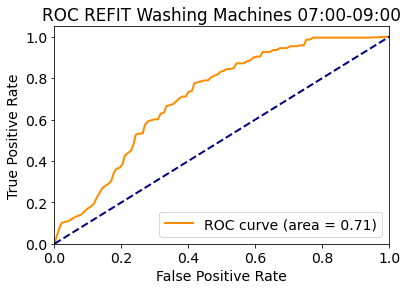

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(states, probs)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC REFIT Washing Machines 07:00-09:00')
plt.legend(loc="lower right")
plt.show()

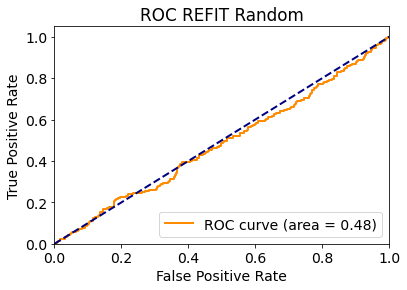

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from scipy import interp
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(states, randprobs)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC REFIT Random')
plt.legend(loc="lower right")
plt.show()